In [1]:
!pip install pyspark==3.5.0 delta-spark==3.1.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=955ea86070c2c10746c6d36f02f02f6d4510c91706d3244369619a7b47b78e67
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [19]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

# Spark session with Delta support
builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Sample data
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

# Create DataFrame
df = spark.createDataFrame(data, columns)

# Save as Delta table in Colab
path = "/content/orders_delta"
df.write.format("delta").mode("overwrite").save(path)




In [21]:
# Dropping tables
spark.sql("DROP TABLE IF EXISTS orders_managed")
spark.sql("DROP TABLE IF EXISTS orders_unmanaged")

#1 Managed Table
spark.sql("CREATE TABLE IF NOT EXISTS orders_managed USING DELTA LOCATION '/content/orders_delta'")

# Unmanaged Table
spark.sql("CREATE TABLE IF NOT EXISTS orders_unmanaged USING DELTA LOCATION '/content/orders_delta'")

print("Managed and Unmanaged tables created")

spark.sql("SHOW TABLES").show()

Managed and Unmanaged tables created
+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|      new_orders|      false|
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



In [5]:
#2 CRUD OPERATIONS
#Read from the table
spark.sql("SELECT * FROM orders_managed").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



In [6]:
#Update table
spark.sql("""
    UPDATE orders_managed
    SET amount = amount + 20
    WHERE category = 'Clothing'
""")


DataFrame[num_affected_rows: bigint]

In [7]:
#Delete table
spark.sql("""
    DELETE FROM orders_managed
    WHERE quantity < 2
""")


DataFrame[num_affected_rows: bigint]

In [8]:
#Merge table
from pyspark.sql import Row

new_data = [
    (3, "Mike", "Electronics", 5, 750),  # updated quantity & amount
    (5, "Emma", "Electronics", 2, 400),  # new order
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
new_df = spark.createDataFrame(new_data, columns)

# Save to temp delta path
temp_path = "/content/new_orders_delta"
new_df.write.format("delta").mode("overwrite").save(temp_path)

# Create temp table for merge
spark.sql(f"CREATE TABLE new_orders USING DELTA LOCATION '{temp_path}'")

# Merge into orders_managed
spark.sql("""
    MERGE INTO orders_managed AS target
    USING new_orders AS source
    ON target.order_id = source.order_id
    WHEN MATCHED THEN UPDATE SET *
    WHEN NOT MATCHED THEN INSERT *
""")


DataFrame[num_affected_rows: bigint, num_updated_rows: bigint, num_deleted_rows: bigint, num_inserted_rows: bigint]

In [9]:
spark.sql("SELECT * FROM orders_managed").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|Electronics|       2|   400|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



In [10]:
# 3 History and Time Travel
spark.sql("DESCRIBE HISTORY orders_managed").show(truncate=False)


+-------+-----------------------+------+--------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|vers

In [11]:
spark.read.format("delta").option("versionAsOf", 0).table("orders_managed").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



In [12]:
spark.sql("SELECT * FROM orders_managed").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|Electronics|       2|   400|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



In [13]:
#4 Incremental load pattern
# New mini-batch data
batch_data = [
    (5, "Emma", "Electronics", 2, 400),
    (6, "Alex", "Clothing", 1, 80),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

# Create DataFrame
batch_df = spark.createDataFrame(batch_data, columns)

# Append to Delta table
batch_df.write.format("delta").mode("append").saveAsTable("orders_managed")

print("Incremental batch appended")

# final result
spark.sql("SELECT * FROM orders_managed").show()


Incremental batch appended
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Emma|Electronics|       2|   400|
|       1|         John|Electronics|       2|   300|
|       5|         Emma|Electronics|       2|   400|
|       6|         Alex|   Clothing|       1|    80|
+--------+-------------+-----------+--------+------+



In [16]:
#5 Simple Streaming Read
from time import sleep

# Streaming read from the Delta table
stream_df = (spark.readStream
             .format("delta")
             .load("/content/orders_delta"))

# Write stream to console
query = (stream_df.writeStream
         .format("console")
         .outputMode("append")
         .trigger(processingTime="5 seconds")
         .start())
sleep(20)
query.stop()



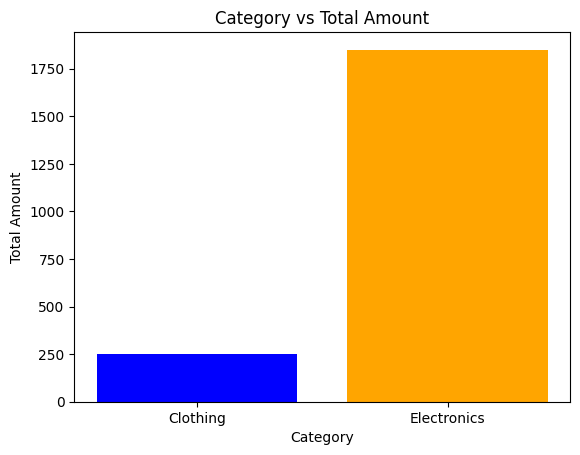

In [17]:
#6 Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Read Delta table into Pandas
pdf = spark.read.format("delta").load("/content/orders_delta").toPandas()

# Group by category and sum the amount
category_amount = pdf.groupby("category")["amount"].sum().reset_index()

# Plot bar chart
plt.bar(category_amount["category"], category_amount["amount"], color=["blue", "orange"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()
